In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
exp_data = pd.read_csv("/home/sreeramp/cancer_dependency_project/sreeram/matrix_factorisation/clean_analysis/data_files/pdx_subset_voom_normalised.csv", 
                       header = 0, index_col = 0)

In [3]:
scaled_exp_data = (exp_data - exp_data.mean()) / exp_data.std()

In [4]:
scaled_exp_data.head()

,A1BG,A4GALT,AAAS,AACS,AADAT,AAGAB,AAK1,AAMP,AARS,AARS2,...,ZW10,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
X-1658,-0.185604,1.151181,-0.144506,-0.634177,0.324255,-0.810046,-1.508332,-0.653703,-0.093462,0.140572,...,-1.530652,0.587676,-0.095681,-0.204130,1.006301,-1.190278,0.660471,0.115825,-0.411639,-0.458849
X-1586,0.923644,0.683454,0.350357,0.003108,0.753166,0.086443,-0.432141,-0.694713,-0.343665,0.579506,...,1.007786,0.785658,-1.026047,-0.699440,-0.416893,0.387765,0.058011,0.115832,-0.512461,0.879940
X-1993,-0.088739,-0.551524,-0.102494,-1.415735,0.388991,1.359098,-0.095180,0.858348,-0.565768,1.082585,...,0.487567,-0.604909,-0.646931,-0.343735,-0.476274,-0.729986,-0.948983,1.095714,-1.756571,-0.134818
X-3843,-2.030226,0.507455,-0.027451,1.470744,0.799502,0.393415,0.038996,0.236151,0.914905,0.556684,...,0.681596,1.354257,1.104802,0.928555,0.492052,-0.092787,0.067048,-0.548531,0.970117,-1.117705
X-1934,1.046880,0.183274,1.156212,0.041145,0.657367,-0.434557,-0.081699,-0.212324,0.238894,0.169174,...,0.283019,0.070663,1.455263,1.170016,-0.018206,0.726645,2.045027,0.706484,0.408226,1.921834


In [4]:
weights_df = pd.read_csv('/home/sreeramp/cancer_dependency_project/sreeram/matrix_factorisation/latent_30_validation/latent30_gene_weights.csv', 
                           index_col = 0, header = 0)
weights_df.head()

,ic50_weight,deps_weight,combined_weight,scaled_combined_weight
EGFR,0.360948,0.005513,2.332825,1.599903
KLK7,-0.094738,0.000341,-0.578267,-0.389472
SLC4A2,0.283241,-0.004950,1.775886,1.219304
PKMP1,0.386586,-0.010572,2.393172,1.641143
TINAGL1,0.087799,0.001058,0.579290,0.401576


In [5]:
# get 200 genes for the W matrix
goI_list = list(weights_df.index)

In [6]:
common_genes = list(set(goI_list) & set(scaled_exp_data.columns))
len(common_genes)

130

In [7]:
missing_genes = list(set(goI_list) - set(scaled_exp_data.columns))
len(missing_genes)

70

In [65]:
print('\n'.join(missing_genes))

TNNI2
DNAJB3
KLK10
EPHA5
CXCR2
CEP295NL
MIR1181
YWHABP2
SPRR1B
NBPF9
KRT8P14
UGT1A7
PFN1P6
MRNIP
NREP
SYT11
RPS20P22
HMGB1P21
KRT8P41
OR2A7
TRAF3IP3
ARHGAP8
TRIM31
FOSL1P1
KPNA7
KLK8
STK26
KCNE4
TCF21
VCAM1
RPA4
CACNG8
FAM25BP
SEPT7P6
DSC2
LINC01085
PKMP1
UBBP4
IQANK1
UGT1A1
RAET1L
TUBB2BP1
KLK7
EPHA1
UGT1A3
TMA16P2
LINC01111
CST6
PDE10A
RPL36AP33
CDH1
KCNH1
PATJ
MIR205
ZNF804A
TUBA1A
MAP1LC3C
TWF1P1
LINC00315
ZNF385C
SDR9C7
LY6D
OMP
SERPINB13
GRIN2B
HTR5BP
UGT1A8
SLC52A3
SYDE1
ARFGAP1


In [8]:
weights_df['missing'] = np.where(weights_df.index.isin(missing_genes), 'yes', 'no')

In [73]:
weights_df.tail()

,ic50_weight,deps_weight,combined_weight,scaled_combined_weight,missing
UGT1A8,-0.301086,0.001813,-1.872395,-1.273850,yes
DMKN,0.229316,0.022107,1.606170,1.103324,no
KRT8P14,0.069040,-0.000338,0.451976,0.314573,yes
CACNG8,-0.329413,-0.001878,-2.074647,-1.412065,yes
HTR5BP,0.064404,0.005442,0.459204,0.319513,yes


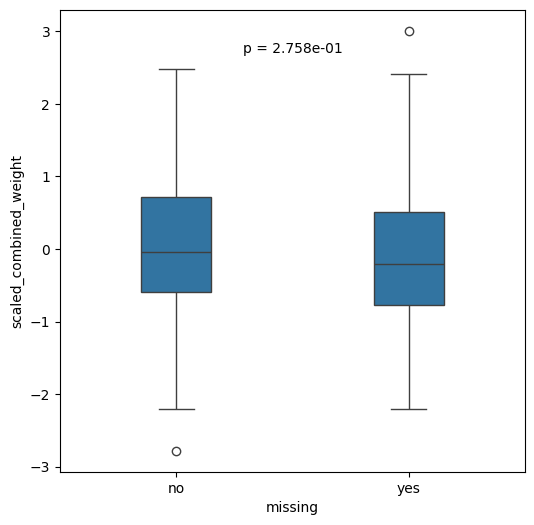

In [10]:
from scipy.stats import ks_2samp, mannwhitneyu

# split data
group1 = weights_df.loc[weights_df['missing'] == 'yes', 'scaled_combined_weight'].dropna()
group2 = weights_df.loc[weights_df['missing'] == 'no', 'scaled_combined_weight'].dropna()

# KS test
ks_stat, p_val = mannwhitneyu(group1, group2, alternative='two-sided')

# boxplot
plt.figure(figsize=(6,6))
sns.boxplot(data=weights_df, x='missing', y='scaled_combined_weight', width = 0.3)

y_max = weights_df['scaled_combined_weight'].max()
plt.text(0.5, y_max * 0.95,       # 95% of max → stays inside
         f"p = {p_val:.3e}", 
         ha='center', va='top', fontsize=10, 
         bbox=dict(facecolor='white', alpha=0.6, edgecolor='none'))  # background box

plt.savefig('../figures/pdx_missingGeneWeights.pdf', dpi=600, bbox_inches='tight')
# plt.title("Missing gene weights in PDX data")
plt.show()

In [84]:
with open('/home/nilabjab/cancer_dependency_project_nilabja/cancer_dependency_project/Approach3_Latent_factor/Figures_latent/Latent_model_40_b0/top_bottom_20_genes.txt', 'r') as f:
  original_list = [i.rstrip().strip() for i in f.readlines()]

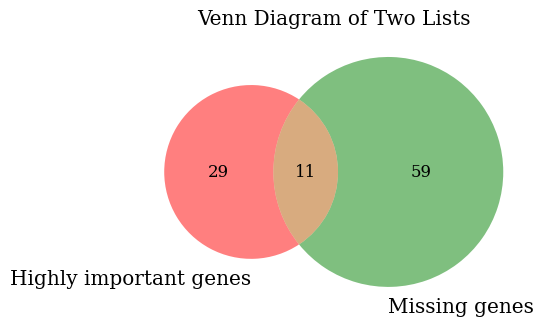

In [85]:
from matplotlib_venn import venn2
# Convert to sets (removes duplicates)
set_a, set_b = set(original_list), set(missing_genes)

# Draw Venn
plt.figure(figsize=(5,5))
v = venn2([set_a, set_b], set_labels=("Highly important genes", "Missing genes"))

# Optional: customize colors/alpha
for patch in ("10", "01", "11"):
    if v.get_patch_by_id(patch):
        v.get_patch_by_id(patch).set_alpha(0.5)

plt.title("Venn Diagram of Two Lists")
plt.show()

In [87]:
common_missing_imp = list(set(original_list) & set(missing_genes))
print('\n'.join(common_missing_imp))

KRT8P41
IQANK1
DNAJB3
KCNE4
TCF21
STK26
OMP
RPA4
TMA16P2
PDE10A
LINC01085


Use the missing genes and get their aliases with Rscript

In [9]:
# read the missing gene synonyms
synonyms_df = pd.read_csv('../data_files/pdx_missing_synonyms_both_versions.csv', header = 0, index_col = 0)
synonyms_df.head()

,hgnc_symbol_grch37,ensembl_ids,synonyms
1,ANXA8,ENSG00000265190,ANX8;ANXA8L1
2,AREG,ENSG00000109321,SDGF;SDGF;SDGF;SDGF;CRDGF;CRDGF;CRDGF;CRDGF;AR...
3,ARFGAP1,ENSG00000101199,bA261N11.3;FLJ10767;FLJ10767;FLJ10767;HRIHFB22...
4,ARHGAP8,ENSG00000241484,BPGAP1;BPGAP1;FLJ20185;FLJ20185;PP610
5,CACNG8,ENSG00000142408,CACNG6


In [10]:
# remove NaN rows
synonyms_df = synonyms_df.dropna(subset=['synonyms'])

Missing genes - genes in weights df but absent in PDX expression

Given a missing gene, search in PDX all its aliases. if match found, add to a dict

In [11]:
mapping_dict = {}

for missing_gene in missing_genes:
    if missing_gene in synonyms_df['hgnc_symbol_grch37'].values:
        # collect all synonyms (in case there are multiple rows per gene)
        synonyms = ';'.join(synonyms_df.loc[synonyms_df['hgnc_symbol_grch37'] == missing_gene, 'synonyms'].astype(str))
        # print(len(synonyms.split(';')))
        all_synonyms = [s.strip() for s in synonyms.split(';') if s.strip()]

        # get all matches with PDX
        matches = [syn for syn in all_synonyms if syn in scaled_exp_data.columns]
        
        if matches:
            print(missing_gene, len(matches))
            mapping_dict[missing_gene] = matches   # store as list of matches


SYT11 1
VCAM1 1
DSC2 2


In [12]:
'L1CAM' in scaled_exp_data.columns

True

In [13]:
'VCAM1' in goI_list

True

In [14]:
mapping_dict

{'SYT11': ['SYT12'], 'VCAM1': ['L1CAM'], 'DSC2': ['DSC3', 'DSC3']}

In [15]:
scaled_exp_data.head()

,A1BG,A4GALT,AAAS,AACS,AADAT,AAGAB,AAK1,AAMP,AARS,AARS2,...,ZW10,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
X-1658,-0.185604,1.151181,-0.144506,-0.634177,0.324255,-0.810046,-1.508332,-0.653703,-0.093462,0.140572,...,-1.530652,0.587676,-0.095681,-0.204130,1.006301,-1.190278,0.660471,0.115825,-0.411639,-0.458849
X-1586,0.923644,0.683454,0.350357,0.003108,0.753166,0.086443,-0.432141,-0.694713,-0.343665,0.579506,...,1.007786,0.785658,-1.026047,-0.699440,-0.416893,0.387765,0.058011,0.115832,-0.512461,0.879940
X-1993,-0.088739,-0.551524,-0.102494,-1.415735,0.388991,1.359098,-0.095180,0.858348,-0.565768,1.082585,...,0.487567,-0.604909,-0.646931,-0.343735,-0.476274,-0.729986,-0.948983,1.095714,-1.756571,-0.134818
X-3843,-2.030226,0.507455,-0.027451,1.470744,0.799502,0.393415,0.038996,0.236151,0.914905,0.556684,...,0.681596,1.354257,1.104802,0.928555,0.492052,-0.092787,0.067048,-0.548531,0.970117,-1.117705
X-1934,1.046880,0.183274,1.156212,0.041145,0.657367,-0.434557,-0.081699,-0.212324,0.238894,0.169174,...,0.283019,0.070663,1.455263,1.170016,-0.018206,0.726645,2.045027,0.706484,0.408226,1.921834


In [16]:
# rename the index usin mapping dict
i = 0
for new, old_list in mapping_dict.items():
  for old_id in old_list:
    if old_id in scaled_exp_data.columns:
      scaled_exp_data.rename({old_id: new}, inplace=True)
      i += 1

In [17]:
scaled_exp_data.head()

,A1BG,A4GALT,AAAS,AACS,AADAT,AAGAB,AAK1,AAMP,AARS,AARS2,...,ZW10,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
X-1658,-0.185604,1.151181,-0.144506,-0.634177,0.324255,-0.810046,-1.508332,-0.653703,-0.093462,0.140572,...,-1.530652,0.587676,-0.095681,-0.204130,1.006301,-1.190278,0.660471,0.115825,-0.411639,-0.458849
X-1586,0.923644,0.683454,0.350357,0.003108,0.753166,0.086443,-0.432141,-0.694713,-0.343665,0.579506,...,1.007786,0.785658,-1.026047,-0.699440,-0.416893,0.387765,0.058011,0.115832,-0.512461,0.879940
X-1993,-0.088739,-0.551524,-0.102494,-1.415735,0.388991,1.359098,-0.095180,0.858348,-0.565768,1.082585,...,0.487567,-0.604909,-0.646931,-0.343735,-0.476274,-0.729986,-0.948983,1.095714,-1.756571,-0.134818
X-3843,-2.030226,0.507455,-0.027451,1.470744,0.799502,0.393415,0.038996,0.236151,0.914905,0.556684,...,0.681596,1.354257,1.104802,0.928555,0.492052,-0.092787,0.067048,-0.548531,0.970117,-1.117705
X-1934,1.046880,0.183274,1.156212,0.041145,0.657367,-0.434557,-0.081699,-0.212324,0.238894,0.169174,...,0.283019,0.070663,1.455263,1.170016,-0.018206,0.726645,2.045027,0.706484,0.408226,1.921834


In [18]:
common_genes = list(set(goI_list) & set(scaled_exp_data.columns))
len(common_genes)

130

In [19]:
filtered_exp_data = scaled_exp_data[common_genes]

In [20]:
weights_df.head()

,ic50_weight,deps_weight,combined_weight,scaled_combined_weight
EGFR,0.360948,0.005513,2.332825,1.599903
KLK7,-0.094738,0.000341,-0.578267,-0.389472
SLC4A2,0.283241,-0.004950,1.775886,1.219304
PKMP1,0.386586,-0.010572,2.393172,1.641143
TINAGL1,0.087799,0.001058,0.579290,0.401576


In [11]:
pdx_weighted_exp = pd.DataFrame(index=scaled_exp_data.index, columns=common_genes)
for gene in common_genes:
  weight = weights_df.loc[gene, 'scaled_combined_weight']
  pdx_weighted_exp[gene] = (scaled_exp_data[gene] * weight).T
pdx_scores = pdx_weighted_exp.sum(axis=1)

In [12]:
pdx_scores

X-1658     3.671132
X-1586     5.038315
X-1993     5.845585
X-3843   -10.891970
X-1934    -5.035992
X-2017    17.287053
X-3237    -2.257453
X-1823    -1.932462
X-4819     6.077908
X-1323    -6.115833
X-2088     1.347417
X-1725     4.002097
X-1834    12.613491
X-1787     7.445250
X-1499   -25.998447
X-2094    -7.302763
X-1683     4.864347
X-1835    -8.369520
X-2082     3.954374
X-2042     7.005338
X-1980    -6.114676
X-1156    -6.202504
X-3029     3.855596
X-1442    -2.400014
X-1172    -0.386268
dtype: float64

In [13]:
# get erlotinib therapy response dataset
metadata_df = pd.read_csv('/home/sreeramp/cancer_dependency_project/sreeram/matrix_factorisation/clean_analysis/data_files/pdx_metadata.csv',
                      header=0, index_col = 0)
metadata_df.head()

,T0,T5,T10,T15,T20,T25,T30,T35,T40,T45,T50,T55,T60,T65,T70,T75,T80,T85,T90,T95
X-0933_BYL719 + cetuximab + encorafenib,NaN,0.2,-24.5,-42.10,-33.1,-33.25,-35.00,-39.5,-34.3,-38.8,-43.75,-40.3,-46.1,-39.55,-37.65,-32.2,NaN,-37.75,-32.3,-40.9
X-0933_BYL719 + cetuximab,NaN,NaN,42.9,80.55,75.4,89.60,123.55,138.9,158.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
X-0933_cetuximab,NaN,-12.6,-4.6,10.00,20.0,61.55,77.90,89.4,93.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
X-0933_cetuximab + encorafenib,NaN,-16.0,-10.4,-37.60,-18.0,-19.20,-11.15,NaN,11.2,21.0,31.70,66.2,62.4,54.50,52.80,124.4,NaN,NaN,NaN,NaN
X-1027_BYL719 + cetuximab + encorafenib,NaN,30.8,56.6,200.20,313.2,446.10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
metadata_df['therapy'] = [i.split("_")[1] for i in metadata_df.index]
metadata_df[metadata_df['therapy'] == 'erlotinib'].shape

(29, 21)

In [15]:
erlotinib_pt = metadata_df[metadata_df['therapy'] == 'erlotinib']
erlotinib_pt.head()

,T0,T5,T10,T15,T20,T25,T30,T35,T40,T45,...,T55,T60,T65,T70,T75,T80,T85,T90,T95,therapy
X-1156_erlotinib,NaN,61.4,202.95,184.80,391.7,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,erlotinib
X-1172_erlotinib,NaN,-0.6,74.00,172.05,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,erlotinib
X-1189_erlotinib,NaN,10.9,-4.05,-5.60,-49.3,-72.30,-79.4,-94.90,-95.6,-100.00,...,NaN,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,erlotinib
X-1228_erlotinib,NaN,-53.6,-54.10,-44.10,-38.3,-32.80,-39.5,-16.85,-18.6,13.15,...,25.8,20.0,30.4,4.6,24.3,17.5,44.6,56.3,7.7,erlotinib
X-1323_erlotinib,NaN,-18.6,-18.90,27.60,57.2,131.15,252.6,307.55,444.4,567.30,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,erlotinib


In [16]:
erlotinib_pt['pdx_id'] = [i.split("_")[0] for i in erlotinib_pt.index]
erlotinib_pt.set_index('pdx_id', drop=True, inplace=True)
erlotinib_pt.drop(columns=['therapy'], inplace=True)
erlotinib_pt.head()

/tmp/ipykernel_746008/2031436105.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  erlotinib_pt['pdx_id'] = [i.split("_")[0] for i in erlotinib_pt.index]
/tmp/ipykernel_746008/2031436105.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  erlotinib_pt.drop(columns=['therapy'], inplace=True)


,T0,T5,T10,T15,T20,T25,T30,T35,T40,T45,T50,T55,T60,T65,T70,T75,T80,T85,T90,T95
pdx_id,,,,,,,,,,,,,,,,,,,,
X-1156,NaN,61.4,202.95,184.80,391.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
X-1172,NaN,-0.6,74.00,172.05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
X-1189,NaN,10.9,-4.05,-5.60,-49.3,-72.30,-79.4,-94.90,-95.6,-100.00,-100.0,NaN,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0
X-1228,NaN,-53.6,-54.10,-44.10,-38.3,-32.80,-39.5,-16.85,-18.6,13.15,-1.8,25.8,20.0,30.4,4.6,24.3,17.5,44.6,56.3,7.7
X-1323,NaN,-18.6,-18.90,27.60,57.2,131.15,252.6,307.55,444.4,567.30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
common_samples = np.intersect1d(erlotinib_pt.index, pdx_scores.index)
clean_data = erlotinib_pt.loc[common_samples]
clean_data = clean_data.drop(columns=[f"T{i}" for i in range(25,100, 5)])
clean_data.drop(columns=['T0'], inplace = True)
clean_data.head()

,T5,T10,T15,T20
pdx_id,,,,
X-1156,61.4,202.95,184.80,391.7
X-1172,-0.6,74.00,172.05,NaN
X-1323,-18.6,-18.90,27.60,57.2
X-1442,-10.4,-3.00,13.60,NaN
X-1499,10.6,93.20,302.45,NaN


In [18]:
# merge scores and response data
clean_data['pdx_scores'] = pdx_scores
clean_data.head()

,T5,T10,T15,T20,pdx_scores
pdx_id,,,,,
X-1156,61.4,202.95,184.80,391.7,-6.202504
X-1172,-0.6,74.00,172.05,NaN,-0.386268
X-1323,-18.6,-18.90,27.60,57.2,-6.115833
X-1442,-10.4,-3.00,13.60,NaN,-2.400014
X-1499,10.6,93.20,302.45,NaN,-25.998447


In [19]:
clean_data['score_cat'] = np.where(clean_data['pdx_scores'] >= np.median(clean_data['pdx_scores']),
                                   'high_score', 'low_score')
clean_data.head()

,T5,T10,T15,T20,pdx_scores,score_cat
pdx_id,,,,,,
X-1156,61.4,202.95,184.80,391.7,-6.202504,low_score
X-1172,-0.6,74.00,172.05,NaN,-0.386268,low_score
X-1323,-18.6,-18.90,27.60,57.2,-6.115833,low_score
X-1442,-10.4,-3.00,13.60,NaN,-2.400014,low_score
X-1499,10.6,93.20,302.45,NaN,-25.998447,low_score


<Axes: xlabel='pdx_scores', ylabel='Density'>

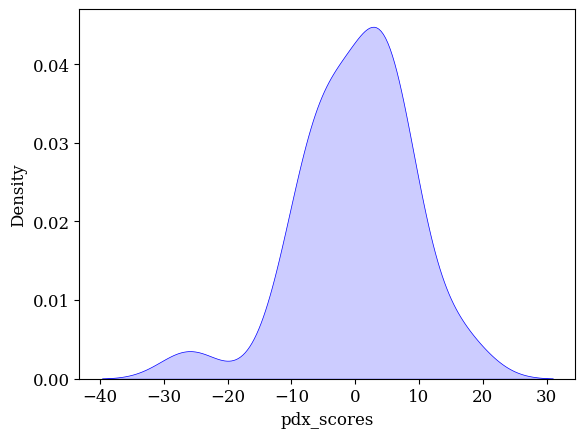

In [45]:
sns.kdeplot(clean_data['pdx_scores'], color='blue', fill=True, alpha=0.2, linewidth = 0.5)

In [30]:
clean_data['score_cat'].value_counts()

score_cat
high_score    13
low_score     12
Name: count, dtype: int64

In [31]:
# clean_data.to_csv('l40_full_analysis_nilabja.csv', index = True)

In [20]:
# create melted df
long_df_data = pd.melt(
    clean_data.reset_index(),  # ensure 'pdx_id' is a column, not index
    id_vars=['pdx_id', 'pdx_scores', 'score_cat'],
    value_vars=['T5', 'T10', 'T15', 'T20'],
    var_name='timepoint',
    value_name='percent_reduction'
)

/tmp/ipykernel_746008/1630017614.py:24: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  sns.stripplot(


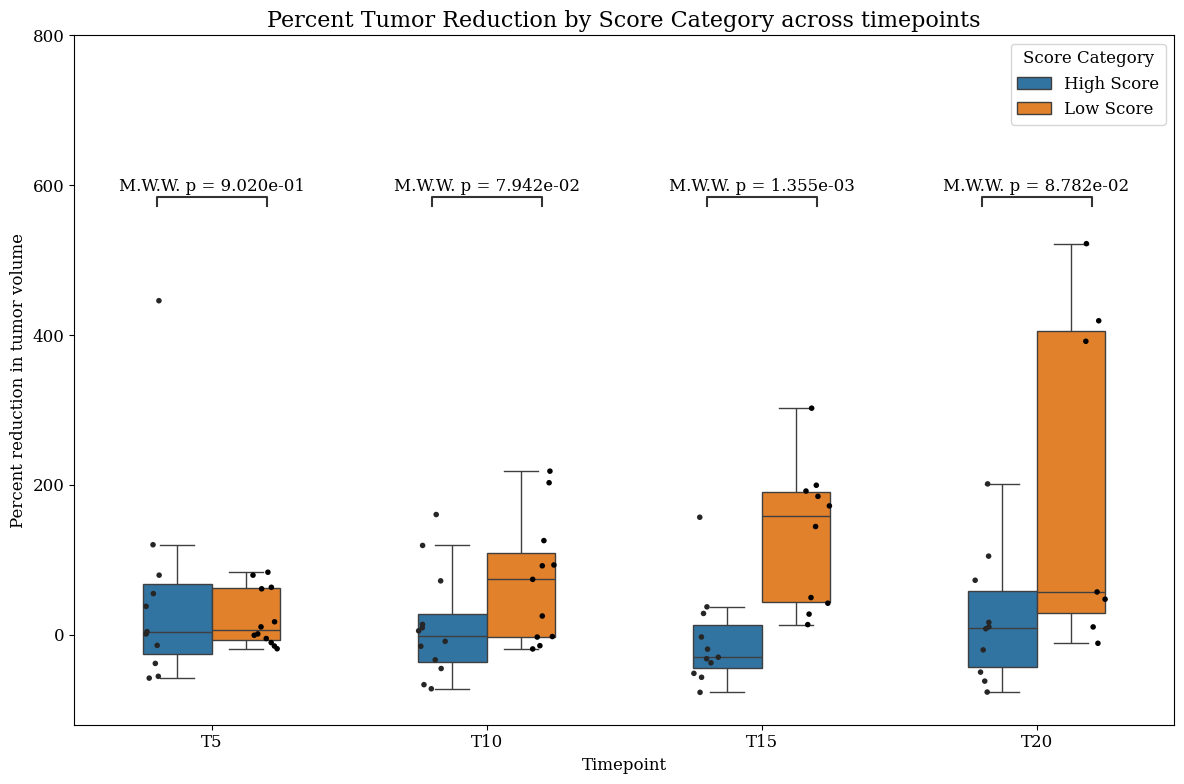

In [21]:
# Set up font and size
from statannotations.Annotator import Annotator
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.size"] = 12  # Increased for better readability
hue_order = ["high_score", "low_score"]
palette = {"high_score": "#1f77b4", "low_score": "#ff7f0e"}

# Set figure size
fig, ax = plt.subplots(figsize=(12,8))

# 1. Draw boxplot
# 1. Draw boxplot with the new, narrower width
sns.boxplot(
    data=long_df_data,
    x="timepoint", y="percent_reduction",
    hue="score_cat", hue_order=hue_order,
    palette=palette,
    ax=ax,
    showfliers=False,
    width=0.5  # <-- The main change here
)

# 2. Overlay stripplot with reduced jitter to match the narrower boxes
sns.stripplot(
    data=long_df_data,
    x="timepoint", y="percent_reduction",
    hue="score_cat", hue_order=hue_order,
    color="black",
    dodge=True,
    jitter=0.1,      # <-- Adjusted to keep points within the box's visual area
    size=4,
    ax=ax
)
# The manual scatter plot loop has been removed as it's no longer needed.

# Define comparisons for p-value annotations
pairs = [
    (("T5", "high_score"), ("T5", "low_score")),
    (("T10", "high_score"), ("T10", "low_score")),
    (("T15", "high_score"), ("T15", "low_score")),
    (("T20", "high_score"), ("T20", "low_score")),
]

# 3. Add p-values using Mann-Whitney U test
annotator = Annotator(ax, pairs, data=long_df_data, x="timepoint", y="percent_reduction", hue="score_cat", hue_order=hue_order)
annotator.configure(
    test='Mann-Whitney',
    text_format='full',
    loc='outside',
    verbose=0 # Hides the statannotations output text
)
annotator.apply_and_annotate()

# 4. Adjust legend
# Adjust legend
handles, labels = ax.get_legend_handles_labels()
# Manually update the labels for better readability
label_map = {'high_score': 'High Score', 'low_score': 'Low Score'}
updated_labels = [label_map.get(lbl, lbl) for lbl in labels]

# Show only the first two handles/labels (for the boxplot)
ax.legend(handles[0:2], updated_labels[0:2], title='Score Category', loc='upper right')

# Final plot adjustments
ax.set_title("Percent Tumor Reduction by Score Category across timepoints", fontsize=16)
ax.set_xlabel('Timepoint', fontsize=12)
ax.set_ylabel('Percent reduction in tumor volume', fontsize=12)
ax.set_ylim(-120, 800)
plt.tight_layout()
plt.savefig(fname = '../figures/pdx_fourDur_response.pdf', dpi = 600)
plt.show()

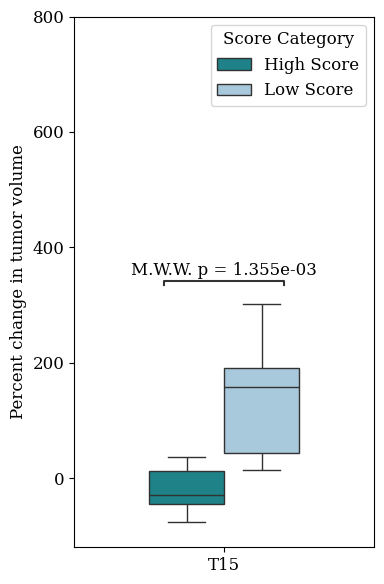

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt
from statannotations.Annotator import Annotator
palette = {'high_score': '#0c919a', 'low_score': '#9fcae3'}
# Filter data to only T15
df_T15 = long_df_data[long_df_data["timepoint"] == "T15"]

# Set up font and size
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.size"] = 12
hue_order = ["high_score", "low_score"]

# Set figure size
fig, ax = plt.subplots(figsize=(4, 6))

# 1. Boxplot
sns.boxplot(
    data=df_T15,
    x="timepoint", y="percent_reduction",
    hue="score_cat", hue_order=hue_order,
    palette=palette,
    ax=ax,
    showfliers=False,
    width=0.5
)

def mannwhitneyu_one_sided(x, y):
    # H0: distributions are the same
    # H1: x < y (i.e. high_score < low_score)
    stat, pval = mannwhitneyu(x, y, alternative="less")
    return stat, pval

pairs = [
    (("T15", "high_score"), ("T15", "low_score")),
]

# 3. Statistical test (only one comparison needed for T15)
pairs = [
    (("T15", "high_score"), ("T15", "low_score")),
]

annotator = Annotator(ax, pairs, data=df_T15, x="timepoint", y="percent_reduction",
                      hue="score_cat", hue_order=hue_order)
annotator.configure(
    test='Mann-Whitney',
    text_format='full',
    loc='outside',
    verbose=0
)
annotator.apply_and_annotate()

# 4. Legend
handles, labels = ax.get_legend_handles_labels()
label_map = {'high_score': 'High Score', 'low_score': 'Low Score'}
updated_labels = [label_map.get(lbl, lbl) for lbl in labels]
ax.legend(handles[0:2], updated_labels[0:2], title='Score Category', loc='upper right')

# Final plot adjustments
# ax.set_title("Percent Tumor Reduction at T15", fontsize=16)
ax.set_xlabel('')
ax.set_ylabel('Percent change in tumor volume', fontsize=12)
ax.set_ylim(-120, 800)
plt.tight_layout()
plt.savefig('../figures/pdx_response_T15.pdf', dpi = 600)
plt.show()


In [59]:
df_T15.head()

,pdx_id,pdx_scores,score_cat,timepoint,percent_reduction
50,X-1156,-6.202504,low_score,T15,184.80
51,X-1172,-0.386268,low_score,T15,172.05
52,X-1323,-6.115833,low_score,T15,27.60
53,X-1442,-2.400014,low_score,T15,13.60
54,X-1499,-25.998447,low_score,T15,302.45


In [61]:
df_T15.groupby('score_cat')['percent_reduction'].describe()

,count,mean,std,min,25%,50%,75%,max
score_cat,,,,,,,,
high_score,11.0,-7.593939,64.525268,-76.8,-44.425,-29.900,12.8000,156.90
low_score,10.0,132.828333,95.168531,13.6,44.025,158.275,190.0875,302.45


In [22]:
other_data = pd.read_csv('../data_files/pdx_other_data.csv', 
                       header = 0, index_col = 0, sep='\t')

In [47]:
other_data.head()

,Treatment,Treatment type,BestResponse,Day_BestResponse,BestAvgResponse,Day_BestAvgResponse,TimeToDouble,Day_Last,ResponseCategory
Model,,,,,,,,,
X-1156,erlotinib,single,486.5,20,130.4,13,4.1,20,PD
X-1172,erlotinib,single,186.4,14,46.1,12,8.6,14,PD
X-1323,erlotinib,single,127.7,21,-4.3,11,19.8,41,PD
X-1442,erlotinib,single,13.6,11,0.0,11,11.0,11,SD
X-1499,erlotinib,single,307.7,15,98.8,14,9.4,15,PD


In [48]:
clean_data.head()

,T5,T10,T15,T20,pdx_scores,score_cat
pdx_id,,,,,,
X-1156,61.4,202.95,184.80,391.7,-6.202504,low_score
X-1172,-0.6,74.00,172.05,NaN,-0.386268,low_score
X-1323,-18.6,-18.90,27.60,57.2,-6.115833,low_score
X-1442,-10.4,-3.00,13.60,NaN,-2.400014,low_score
X-1499,10.6,93.20,302.45,NaN,-25.998447,low_score


In [23]:
merged_df = pd.concat([clean_data, other_data], join='inner', axis = 1)
df2 = merged_df.sort_values(by = 'BestAvgResponse', axis=0, ascending=False)

In [24]:
merged_df.head()

,T5,T10,T15,T20,pdx_scores,score_cat,Treatment,Treatment type,BestResponse,Day_BestResponse,BestAvgResponse,Day_BestAvgResponse,TimeToDouble,Day_Last,ResponseCategory
X-1156,61.4,202.95,184.80,391.7,-6.202504,low_score,erlotinib,single,486.5,20,130.4,13,4.1,20,PD
X-1172,-0.6,74.00,172.05,NaN,-0.386268,low_score,erlotinib,single,186.4,14,46.1,12,8.6,14,PD
X-1323,-18.6,-18.90,27.60,57.2,-6.115833,low_score,erlotinib,single,127.7,21,-4.3,11,19.8,41,PD
X-1442,-10.4,-3.00,13.60,NaN,-2.400014,low_score,erlotinib,single,13.6,11,0.0,11,11.0,11,SD
X-1499,10.6,93.20,302.45,NaN,-25.998447,low_score,erlotinib,single,307.7,15,98.8,14,9.4,15,PD


In [25]:
conditions = [
    (merged_df["BestResponse"] < -95) & (merged_df["BestAvgResponse"] < -40),  # mCR
    (merged_df["BestResponse"] < -50) & (merged_df["BestAvgResponse"] < -20),  # mPR
    (merged_df["BestResponse"] < 35) & (merged_df["BestAvgResponse"] < 30)    # mSD
]

# Define corresponding categories
choices = ["mCR", "mPR", "mSD"]

# Apply conditions, default "mPD"
merged_df["mRECIST"] = np.select(conditions, choices, default="mPD")

In [64]:
pd.crosstab(merged_df["mRECIST"], merged_df["score_cat"])

score_cat,high_score,low_score
mRECIST,,
mPD,5,9
mPR,3,0
mSD,5,3


In [51]:
df2.head()

,T5,T10,T15,T20,pdx_scores,score_cat,Treatment,Treatment type,BestResponse,Day_BestResponse,BestAvgResponse,Day_BestAvgResponse,TimeToDouble,Day_Last,ResponseCategory
X-4819,445.85,NaN,NaN,NaN,6.077908,high_score,erlotinib,single,553.9,5,297.2,5,3.0,5,PD
X-1156,61.40,202.95,184.80,391.7,-6.202504,low_score,erlotinib,single,486.5,20,130.4,13,4.1,20,PD
X-2094,63.40,125.70,199.60,419.1,-7.302763,low_score,erlotinib,single,494.3,20,102.9,13,6.3,20,PD
X-1499,10.60,93.20,302.45,NaN,-25.998447,low_score,erlotinib,single,307.7,15,98.8,14,9.4,15,PD
X-1934,83.50,218.40,NaN,NaN,-5.035992,low_score,erlotinib,single,218.4,7,96.4,7,3.3,7,PD


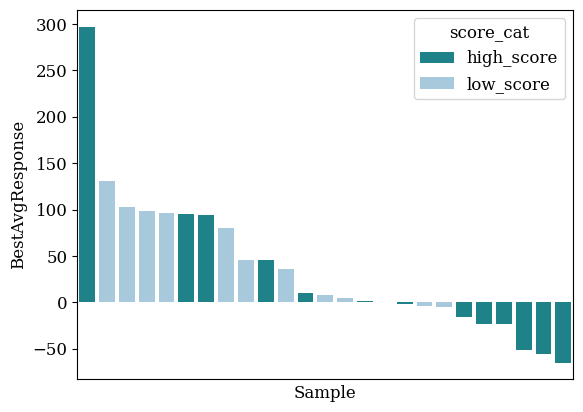

In [27]:
palette = {'high_score': '#0c919a', 'low_score': '#9fcae3'}
sns.barplot(data = df2, x = df2.index, y = 'BestAvgResponse', hue = 'score_cat', palette = palette)
plt.xticks([])
plt.xlabel('Sample')
plt.savefig('../figures/pdx_bestAvgResponses.pdf', dpi=600, bbox_inches='tight')
plt.show()

In [42]:
clean_data.to_csv('../data_files/pdx_score_responses.csv', index=True)